# Import libraries

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch

import config as CFG
import utils
from Data.calib_loader import CalibDataset
from models.MulCal_v2 import MulCal
from models.msjf import MSJF

In [2]:
# Fixing random seeds
torch.manual_seed(1368)
rs = np.random.RandomState(1368)

In [3]:
# Matplotlib config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

# Load data

In [4]:
# Prepare dataset
X_train, y_train, lab_train, X_val, y_val, lab_val, X_test, y_test, lab_test = utils.prepare_multicalib_dataset(single=False)
X_mean = X_train.mean(axis=0).mean(axis=1)
X_std = X_train.std(axis=0).mean(axis=1)

test_loader = torch.utils.data.DataLoader(CalibDataset(X_test, y_test, lab_test), batch_size=CFG.batch_size, shuffle=False)

# Load model

In [5]:
# Load model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = MulCal(CFG.input_dim, CFG.hidden_dim, CFG.output_dim, CFG.n_class, device, X_mean, X_std, noise=True, new_gen=False)
model.load_state_dict(torch.load(f"./logs/fimicalib/multi_best.pt", map_location=device))
model.to(device)
model.eval()

MulCal(
  (extractor): SeriesEncoder(
    (lstm): LSTM(4, 64)
    (bilstm): LSTM(64, 62, bidirectional=True)
  )
  (identity): IdentityLayer_v2(
    (module): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (seperate_module): IdentityMergingModule(
    (query_tfm): Linear(in_features=64, out_features=128, bias=True)
    (context_lstm): LSTM(640, 640, batch_first=True)
    (score_module): Sequential(
      (0): Linear(in_features=128, out_features=384, bias=True)
      (1): LeakyReLU(negative_slope=0.02)
      (2): Linear(in_features=384, out_features=15, bias=True)
    )
    (tanh): Tanh()
    (softmax): Softmax(dim=-1)
  )
  (calib): IdentityAwaredCalibModule_v2(
    (identity_latent): Linear(in_features=128, out_features=64, bias=True)
    (x_latent): Linear(in_features=128, out_features=64, bias=True)
    (attention_i): Attention(
      (fc): Linear(in_features=64, ou

# Inference function

In [6]:
# Inference function
def infer(x, lab):
    noise_batch = torch.tensor(rs.normal(0, 1, (x.size(0), CFG.input_timestep, CFG.noise_dim)), device=device, dtype=torch.float32)
    pred, _ = model(x, lab, noise_batch)
    return pred

# Inference

In [9]:
x, y, lab = next(iter(test_loader))
x = x.to(device)
lab = lab.to(device)
preds = infer(x, lab)

x = x.detach().cpu()
lab = lab.detach().cpu()
preds = preds.detach().cpu()

# Visualization

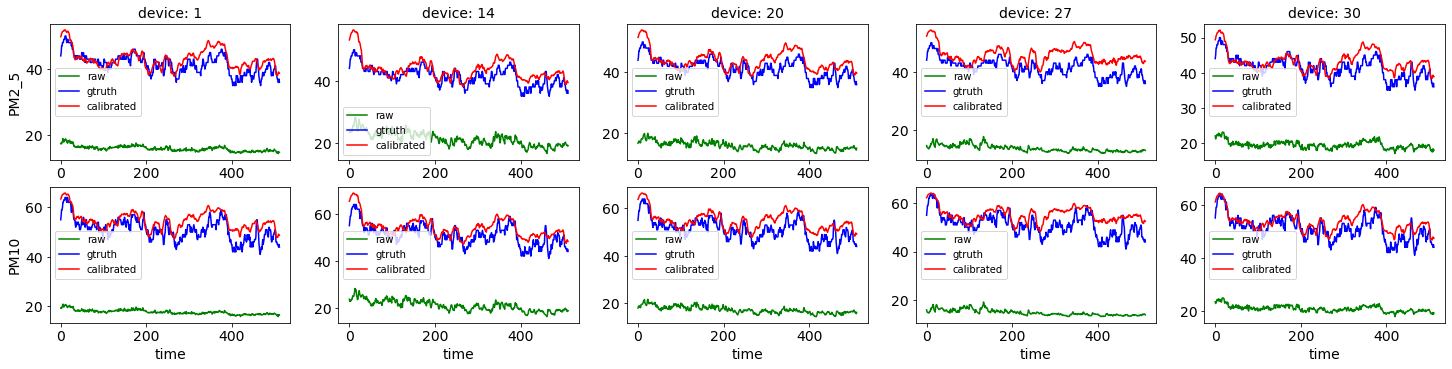

In [10]:
# Plot
atts = ['PM2_5', 'PM10']
ids = ['1', '14', '20', '27', '30']
fig, ax = plt.subplots(len(atts), len(ids), figsize=(25, 5.5))

for i, idx in enumerate(ids):                                  
    for j, att in enumerate(atts):                             
        x_i = x[:, i, 0, j]                          
        y_i = y[:, i, 0, j]                          
        pred_i = preds[:, i, 0, j]                             

        rn_test = range(x_i.shape[0])                          
        ax[j, i].plot(rn_test, x_i, 'g', label='raw')          
        ax[j, i].plot(rn_test, y_i, 'b', label='gtruth')       
        ax[j, i].plot(rn_test, pred_i, 'r', label='calibrated')
        ax[j, i].legend(loc='best')
        if j == 0:
            ax[j, i].set_title(f"device: {idx}")  
        if j == len(atts) - 1:
            ax[j, i].set_xlabel("time")
        if i == 0:
            ax[j, i].set_ylabel(att)                               
    
fig.savefig(f"./logs/test.png")